<a href="https://colab.research.google.com/github/hazemAI/store/blob/main/phase1_selected_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision import transforms, models, datasets
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from functools import partial
import random
import math
import copy

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

num_epochs = 10
batch_size = 32
num_workers = 2  # Adjust based on system capabilities
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'


train_dir = '/content/drive/MyDrive/cifake/train'
test_dir = '/content/drive/MyDrive/cifake/test'



train_dataset = datasets.ImageFolder(train_dir)
test_dataset = datasets.ImageFolder(test_dir)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  #use imagenet mean and std
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

# Ensure the class labels are encoded as 0 (fake) and 1 (real)
class_to_idx = {'fake': 0, 'real': 1}
train_dataset.class_to_idx = class_to_idx
test_dataset.class_to_idx = class_to_idx

# Define models
models_list = [
     ('AlexNet', models.alexnet(weights=models.AlexNet_Weights.DEFAULT)),
    ('VGG16', models.vgg16(weights=models.VGG16_Weights.DEFAULT)),
    ('LeNet5', None),
]


# Define LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self, num_classes=1):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.avg_pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.avg_pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.avg_pool2(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        return x

# Function to reset model weights
def reset_model(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

# Function to create model with new classifier
def create_model(model_name, model=None):
    if model_name == 'AlexNet':
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_features, 1)
    elif model_name == 'VGG16':
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_features, 1)
    elif model_name == 'LeNet5':
        model = LeNet5(num_classes=1)
    return model

# Function to evaluate model performance
def evaluate_model(model, device, dataloader, model_name):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            preds = (probabilities > 0.5).int().flatten()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=1)
    rec = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    return cm, acc, prec, rec, f1

# Simulated Annealing for Hyperparameter Optimization
def simulated_annealing(objective_func, initial_lr, temp_init, temp_min, alpha, num_iterations):
    current_lr = initial_lr
    current_score = objective_func(current_lr)
    best_lr = current_lr
    best_score = current_score
    for iteration in range(num_iterations):
        temp = temp_init * (alpha ** iteration)
        if temp < temp_min:
            break
        new_lr = current_lr * (1 + random.uniform(-0.9, 0.9))
        new_lr = max(new_lr, 1e-8)
        new_lr = min(new_lr, 1e-3)
        new_score = objective_func(new_lr)
        if new_score > current_score or random.random() < math.exp((new_score - current_score) / temp):
            current_lr = new_lr
            current_score = new_score
        if new_score > best_score:
            best_lr = new_lr
            best_score = new_score
    return best_lr, best_score

# Performance metrics storage
metrics = {}



# Main training and validation loop
for model_name, model in models_list:
    print(f"Training {model_name}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    fold_performance = []

    for fold, (train_indices, indices) in enumerate(kf.split(train_dataset)):
        if model_name != 'LeNet5':
            model = create_model(model_name, model)
        else:
            model = create_model(model_name)
        model.to(device)
        reset_model(model)
        initial_state = copy.deepcopy(model.state_dict())
        print(f"Fold {fold + 1} ({model_name})")

        # Dataloaders for this fold
        train_sampler = SubsetRandomSampler(train_indices)
        sampler = SubsetRandomSampler(indices)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers, pin_memory=True)
        loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers, pin_memory=True)

        # Objective function for Simulated Annealing
        def objective_func(lr, model_name, model):
            print(f"Trying learning rate: {lr:.10f}")  # Print the learning rate being evaluated
            temp_model = copy.deepcopy(model)
            temp_model.load_state_dict(initial_state)
            temp_model.to(device)
            criterion = nn.BCEWithLogitsLoss()
            optimizer = optim.Adam(temp_model.parameters(), lr=lr)
            num_epochs_sa = 3  # Reduced number of epochs for simulated annealing
            for epoch in range(num_epochs_sa):
                temp_model.train()
                running_loss = 0.0
                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                    optimizer.zero_grad()
                    outputs = temp_model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
            cm, acc, prec, rec, f1 = evaluate_model(temp_model, device, loader, model_name)
            print(f"Score: {acc}\n")
            return acc

        # Partial function to fix model_name and model
        objective_func_partial = partial(objective_func, model_name=model_name, model=model)

        # Run Simulated Annealing with optimization parameters
        initial_lr = 1e-6
        temp_init = 1.0
        temp_min = 1e-7
        alpha = 0.90
        num_iterations_sa = 10  # Reduced number of iterations
        best_lr, best_score = simulated_annealing(objective_func_partial, initial_lr, temp_init, temp_min, alpha, num_iterations_sa)
        print(f"Best learning rate for fold {fold + 1}: {best_lr:.10f}")

        # Re-train the model with the best learning rate for this fold
        reset_model(model)
        model.to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=best_lr)

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

        cm, acc, prec, rec, f1 = evaluate_model(model, device, loader, model_name)
        fold_performance.append({'cm': cm, 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'best_lr': best_lr})
        print(f"Fold {fold + 1} ({model_name}) Performance:")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"F1-Score: {f1:.4f}")


    # Average metrics across folds
    avg_cm = np.mean([fold['cm'] for fold in fold_performance], axis=0)
    avg_acc = np.mean([fold['acc'] for fold in fold_performance])
    avg_prec = np.mean([fold['prec'] for fold in fold_performance])
    avg_rec = np.mean([fold['rec'] for fold in fold_performance])
    avg_f1 = np.mean([fold['f1'] for fold in fold_performance])

    metrics[model_name] = {
        'avg_cm': avg_cm,
        'avg_acc': avg_acc,
        'avg_prec': avg_prec,
        'avg_rec': avg_rec,
        'avg_f1': avg_f1,
        'fold_performance': fold_performance
    }

    print(f"Average Performance for {model_name}:")
    print(f"Confusion Matrix:\n{avg_cm}")
    print(f"Accuracy: {avg_acc:.4f}")
    print(f"Precision: {avg_prec:.4f}")
    print(f"Recall: {avg_rec:.4f}")
    print(f"F1-Score: {avg_f1:.4f}")

    # Re-train the model with the best learning rate from all folds
    best_fold = np.argmax([fold['acc'] for fold in fold_performance])
    best_lr = fold_performance[best_fold]['best_lr']
    print(f"Best learning rate for {model_name}: {best_lr}")

    reset_model(model)
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")


    # Final model evaluation on test set
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    cm, acc, prec, rec, f1 = evaluate_model(model, device, test_loader, model_name)
    print(f"Final Model Performance for {model_name}:")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")

Training AlexNet
Fold 1 (AlexNet)
Trying learning rate: 0.0000010000
Score: 0.7083832335329341

Trying learning rate: 0.0000012510
Score: 0.7470059880239521

Trying learning rate: 0.0000001814
Score: 0.61437125748503

Trying learning rate: 0.0000000910
Score: 0.5862275449101796

Trying learning rate: 0.0000001200
Score: 0.579940119760479

Trying learning rate: 0.0000000308
Score: 0.5353293413173653

Trying learning rate: 0.0000000100
Score: 0.5254491017964071

Trying learning rate: 0.0000000101
Score: 0.5362275449101797

Trying learning rate: 0.0000000100
Score: 0.5296407185628742

Trying learning rate: 0.0000000127
Score: 0.5248502994011977

Trying learning rate: 0.0000000100
Score: 0.5275449101796407

Best learning rate for fold 1: 0.0000012510
Epoch 1/10, Loss: 0.6627
Epoch 2/10, Loss: 0.6038


In [ ]:
import torch
import torchvision
from torchvision import transforms, models, datasets
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from functools import partial
import random
import math
import copy

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

num_epochs = 10
batch_size = 32
num_workers = 2  # Adjust based on system capabilities
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'


train_dir = '/content/drive/MyDrive/cifake/train'
test_dir = '/content/drive/MyDrive/cifake/test'



train_dataset = datasets.ImageFolder(train_dir)
test_dataset = datasets.ImageFolder(test_dir)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  #use imagenet mean and std
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

# Ensure the class labels are encoded as 0 (fake) and 1 (real)
class_to_idx = {'fake': 0, 'real': 1}
train_dataset.class_to_idx = class_to_idx
test_dataset.class_to_idx = class_to_idx

# Define models
models_list = [
     ('AlexNet', models.alexnet(weights=models.AlexNet_Weights.DEFAULT)),
    ('VGG16', models.vgg16(weights=models.VGG16_Weights.DEFAULT)),
    ('LeNet5', None),
]


# Define LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self, num_classes=1):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.avg_pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.avg_pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.avg_pool2(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        return x

# Function to reset model weights
def reset_model(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

# Function to create model with new classifier
def create_model(model_name, model=None):
    if model_name == 'AlexNet':
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_features, 1)
    elif model_name == 'VGG16':
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_features, 1)
    elif model_name == 'LeNet5':
        model = LeNet5(num_classes=1)
    return model

# Function to evaluate model performance
def evaluate_model(model, device, dataloader, model_name):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            preds = (probabilities > 0.5).int().flatten()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=1)
    rec = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    return cm, acc, prec, rec, f1

# Simulated Annealing for Hyperparameter Optimization
def simulated_annealing(objective_func, initial_lr, temp_init, temp_min, alpha, num_iterations):
    current_lr = initial_lr
    current_score = objective_func(current_lr)
    best_lr = current_lr
    best_score = current_score
    for iteration in range(num_iterations):
        temp = temp_init * (alpha ** iteration)
        if temp < temp_min:
            break
        new_lr = current_lr * (1 + random.uniform(-0.9, 0.9))
        new_lr = max(new_lr, 1e-8)
        new_lr = min(new_lr, 1e-3)
        new_score = objective_func(new_lr)
        if new_score > current_score or random.random() < math.exp((new_score - current_score) / temp):
            current_lr = new_lr
            current_score = new_score
        if new_score > best_score:
            best_lr = new_lr
            best_score = new_score
    return best_lr, best_score

# Performance metrics storage
metrics = {}



# Main training and validation loop
for model_name, model in models_list:
    print(f"Training {model_name}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    fold_performance = []

    for fold, (train_indices, indices) in enumerate(kf.split(train_dataset)):
        if model_name != 'LeNet5':
            model = create_model(model_name, model)
        else:
            model = create_model(model_name)
        model.to(device)
        reset_model(model)
        initial_state = copy.deepcopy(model.state_dict())
        print(f"Fold {fold + 1} ({model_name})")

        # Dataloaders for this fold
        train_sampler = SubsetRandomSampler(train_indices)
        sampler = SubsetRandomSampler(indices)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers, pin_memory=True)
        loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers, pin_memory=True)

        # Objective function for Simulated Annealing
        def objective_func(lr, model_name, model):
            print(f"Trying learning rate: {lr:.10f}")  # Print the learning rate being evaluated
            temp_model = copy.deepcopy(model)
            temp_model.load_state_dict(initial_state)
            temp_model.to(device)
            criterion = nn.BCEWithLogitsLoss()
            optimizer = optim.Adam(temp_model.parameters(), lr=lr)
            num_epochs_sa = 3  # Reduced number of epochs for simulated annealing
            for epoch in range(num_epochs_sa):
                temp_model.train()
                running_loss = 0.0
                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                    optimizer.zero_grad()
                    outputs = temp_model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
            cm, acc, prec, rec, f1 = evaluate_model(temp_model, device, loader, model_name)
            print(f"Score: {acc}\n")
            return acc

        # Partial function to fix model_name and model
        objective_func_partial = partial(objective_func, model_name=model_name, model=model)

        # Run Simulated Annealing with optimization parameters
        initial_lr = 1e-6
        temp_init = 1.0
        temp_min = 1e-7
        alpha = 0.90
        num_iterations_sa = 10  # Reduced number of iterations
        best_lr, best_score = simulated_annealing(objective_func_partial, initial_lr, temp_init, temp_min, alpha, num_iterations_sa)
        print(f"Best learning rate for fold {fold + 1}: {best_lr:.10f}")

        # Re-train the model with the best learning rate for this fold
        reset_model(model)
        model.to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=best_lr)

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

        cm, acc, prec, rec, f1 = evaluate_model(model, device, loader, model_name)
        fold_performance.append({'cm': cm, 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'best_lr': best_lr})
        print(f"Fold {fold + 1} ({model_name}) Performance:")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"F1-Score: {f1:.4f}")


    # Average metrics across folds
    avg_cm = np.mean([fold['cm'] for fold in fold_performance], axis=0)
    avg_acc = np.mean([fold['acc'] for fold in fold_performance])
    avg_prec = np.mean([fold['prec'] for fold in fold_performance])
    avg_rec = np.mean([fold['rec'] for fold in fold_performance])
    avg_f1 = np.mean([fold['f1'] for fold in fold_performance])

    metrics[model_name] = {
        'avg_cm': avg_cm,
        'avg_acc': avg_acc,
        'avg_prec': avg_prec,
        'avg_rec': avg_rec,
        'avg_f1': avg_f1,
        'fold_performance': fold_performance
    }

    print(f"Average Performance for {model_name}:")
    print(f"Confusion Matrix:\n{avg_cm}")
    print(f"Accuracy: {avg_acc:.4f}")
    print(f"Precision: {avg_prec:.4f}")
    print(f"Recall: {avg_rec:.4f}")
    print(f"F1-Score: {avg_f1:.4f}")

    # Re-train the model with the best learning rate from all folds
    best_fold = np.argmax([fold['acc'] for fold in fold_performance])
    best_lr = fold_performance[best_fold]['best_lr']
    print(f"Best learning rate for {model_name}: {best_lr}")

    reset_model(model)
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")


    # Final model evaluation on test set
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    cm, acc, prec, rec, f1 = evaluate_model(model, device, test_loader, model_name)
    print(f"Final Model Performance for {model_name}:")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")

Training AlexNet
Fold 1 (AlexNet)
Trying learning rate: 0.0000010000
Score: 0.7083832335329341

Trying learning rate: 0.0000012510
Score: 0.7470059880239521

Trying learning rate: 0.0000001814
Score: 0.61437125748503

Trying learning rate: 0.0000000910
Score: 0.5862275449101796

Trying learning rate: 0.0000001200
Score: 0.579940119760479

Trying learning rate: 0.0000000308
Score: 0.5353293413173653

Trying learning rate: 0.0000000100
Score: 0.5254491017964071

Trying learning rate: 0.0000000101
Score: 0.5362275449101797

Trying learning rate: 0.0000000100
Score: 0.5296407185628742

Trying learning rate: 0.0000000127
Score: 0.5248502994011977

Trying learning rate: 0.0000000100
Score: 0.5275449101796407

Best learning rate for fold 1: 0.0000012510
Epoch 1/10, Loss: 0.6627
Epoch 2/10, Loss: 0.6038


In [ ]:
import torch
import torchvision
from torchvision import transforms, models, datasets
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from functools import partial
import random
import math
import copy

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

num_epochs = 10
batch_size = 32
num_workers = 2  # Adjust based on system capabilities
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'


train_dir = '/content/drive/MyDrive/cifake/train'
test_dir = '/content/drive/MyDrive/cifake/test'



train_dataset = datasets.ImageFolder(train_dir)
test_dataset = datasets.ImageFolder(test_dir)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  #use imagenet mean and std
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

# Ensure the class labels are encoded as 0 (fake) and 1 (real)
class_to_idx = {'fake': 0, 'real': 1}
train_dataset.class_to_idx = class_to_idx
test_dataset.class_to_idx = class_to_idx

# Define models
models_list = [
     ('AlexNet', models.alexnet(weights=models.AlexNet_Weights.DEFAULT)),
    ('VGG16', models.vgg16(weights=models.VGG16_Weights.DEFAULT)),
    ('LeNet5', None),
]


# Define LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self, num_classes=1):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.avg_pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.avg_pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.avg_pool2(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        return x

# Function to reset model weights
def reset_model(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

# Function to create model with new classifier
def create_model(model_name, model=None):
    if model_name == 'AlexNet':
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_features, 1)
    elif model_name == 'VGG16':
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_features, 1)
    elif model_name == 'LeNet5':
        model = LeNet5(num_classes=1)
    return model

# Function to evaluate model performance
def evaluate_model(model, device, dataloader, model_name):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            preds = (probabilities > 0.5).int().flatten()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=1)
    rec = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    return cm, acc, prec, rec, f1

# Simulated Annealing for Hyperparameter Optimization
def simulated_annealing(objective_func, initial_lr, temp_init, temp_min, alpha, num_iterations):
    current_lr = initial_lr
    current_score = objective_func(current_lr)
    best_lr = current_lr
    best_score = current_score
    for iteration in range(num_iterations):
        temp = temp_init * (alpha ** iteration)
        if temp < temp_min:
            break
        new_lr = current_lr * (1 + random.uniform(-0.9, 0.9))
        new_lr = max(new_lr, 1e-8)
        new_lr = min(new_lr, 1e-3)
        new_score = objective_func(new_lr)
        if new_score > current_score or random.random() < math.exp((new_score - current_score) / temp):
            current_lr = new_lr
            current_score = new_score
        if new_score > best_score:
            best_lr = new_lr
            best_score = new_score
    return best_lr, best_score

# Performance metrics storage
metrics = {}



# Main training and validation loop
for model_name, model in models_list:
    print(f"Training {model_name}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    fold_performance = []

    for fold, (train_indices, indices) in enumerate(kf.split(train_dataset)):
        if model_name != 'LeNet5':
            model = create_model(model_name, model)
        else:
            model = create_model(model_name)
        model.to(device)
        reset_model(model)
        initial_state = copy.deepcopy(model.state_dict())
        print(f"Fold {fold + 1} ({model_name})")

        # Dataloaders for this fold
        train_sampler = SubsetRandomSampler(train_indices)
        sampler = SubsetRandomSampler(indices)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers, pin_memory=True)
        loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers, pin_memory=True)

        # Objective function for Simulated Annealing
        def objective_func(lr, model_name, model):
            print(f"Trying learning rate: {lr:.10f}")  # Print the learning rate being evaluated
            temp_model = copy.deepcopy(model)
            temp_model.load_state_dict(initial_state)
            temp_model.to(device)
            criterion = nn.BCEWithLogitsLoss()
            optimizer = optim.Adam(temp_model.parameters(), lr=lr)
            num_epochs_sa = 3  # Reduced number of epochs for simulated annealing
            for epoch in range(num_epochs_sa):
                temp_model.train()
                running_loss = 0.0
                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                    optimizer.zero_grad()
                    outputs = temp_model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
            cm, acc, prec, rec, f1 = evaluate_model(temp_model, device, loader, model_name)
            print(f"Score: {acc}\n")
            return acc

        # Partial function to fix model_name and model
        objective_func_partial = partial(objective_func, model_name=model_name, model=model)

        # Run Simulated Annealing with optimization parameters
        initial_lr = 1e-6
        temp_init = 1.0
        temp_min = 1e-7
        alpha = 0.90
        num_iterations_sa = 10  # Reduced number of iterations
        best_lr, best_score = simulated_annealing(objective_func_partial, initial_lr, temp_init, temp_min, alpha, num_iterations_sa)
        print(f"Best learning rate for fold {fold + 1}: {best_lr:.10f}")

        # Re-train the model with the best learning rate for this fold
        reset_model(model)
        model.to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=best_lr)

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

        cm, acc, prec, rec, f1 = evaluate_model(model, device, loader, model_name)
        fold_performance.append({'cm': cm, 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'best_lr': best_lr})
        print(f"Fold {fold + 1} ({model_name}) Performance:")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"F1-Score: {f1:.4f}")


    # Average metrics across folds
    avg_cm = np.mean([fold['cm'] for fold in fold_performance], axis=0)
    avg_acc = np.mean([fold['acc'] for fold in fold_performance])
    avg_prec = np.mean([fold['prec'] for fold in fold_performance])
    avg_rec = np.mean([fold['rec'] for fold in fold_performance])
    avg_f1 = np.mean([fold['f1'] for fold in fold_performance])

    metrics[model_name] = {
        'avg_cm': avg_cm,
        'avg_acc': avg_acc,
        'avg_prec': avg_prec,
        'avg_rec': avg_rec,
        'avg_f1': avg_f1,
        'fold_performance': fold_performance
    }

    print(f"Average Performance for {model_name}:")
    print(f"Confusion Matrix:\n{avg_cm}")
    print(f"Accuracy: {avg_acc:.4f}")
    print(f"Precision: {avg_prec:.4f}")
    print(f"Recall: {avg_rec:.4f}")
    print(f"F1-Score: {avg_f1:.4f}")

    # Re-train the model with the best learning rate from all folds
    best_fold = np.argmax([fold['acc'] for fold in fold_performance])
    best_lr = fold_performance[best_fold]['best_lr']
    print(f"Best learning rate for {model_name}: {best_lr}")

    reset_model(model)
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")


    # Final model evaluation on test set
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    cm, acc, prec, rec, f1 = evaluate_model(model, device, test_loader, model_name)
    print(f"Final Model Performance for {model_name}:")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")

Training AlexNet
Fold 1 (AlexNet)
Trying learning rate: 0.0000010000
Score: 0.7083832335329341

Trying learning rate: 0.0000012510
Score: 0.7470059880239521

Trying learning rate: 0.0000001814
Score: 0.61437125748503

Trying learning rate: 0.0000000910
Score: 0.5862275449101796

Trying learning rate: 0.0000001200
Score: 0.579940119760479

Trying learning rate: 0.0000000308
Score: 0.5353293413173653

Trying learning rate: 0.0000000100
Score: 0.5254491017964071

Trying learning rate: 0.0000000101
Score: 0.5362275449101797

Trying learning rate: 0.0000000100
Score: 0.5296407185628742

Trying learning rate: 0.0000000127
Score: 0.5248502994011977

Trying learning rate: 0.0000000100
Score: 0.5275449101796407

Best learning rate for fold 1: 0.0000012510
Epoch 1/10, Loss: 0.6627
Epoch 2/10, Loss: 0.6038


usage: kaggle [-h] [-v] [-W] {competitions,c,datasets,d,kernels,k,models,m,files,f,config} ...
kaggle: error: unrecognized arguments: --file LRW-AR.zip


In [ ]:
# !unzip /content/drive/MyDrive/Datasets/cifake1.zip
!unzip /content/drive/MyDrive/Datasets/cifake1.zip -d /content/drive/MyDrive/Datasets/cifake

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Datasets/cifake/cifake/train/real/0001 (10).jpg  
  inflating: /content/drive/MyDrive/Datasets/cifake/cifake/train/real/0001 (2).jpg  
  inflating: /content/drive/MyDrive/Datasets/cifake/cifake/train/real/0001 (3).jpg  
  inflating: /content/drive/MyDrive/Datasets/cifake/cifake/train/real/0001 (4).jpg  
  inflating: /content/drive/MyDrive/Datasets/cifake/cifake/train/real/0001 (5).jpg  
  inflating: /content/drive/MyDrive/Datasets/cifake/cifake/train/real/0001 (6).jpg  
  inflating: /content/drive/MyDrive/Datasets/cifake/cifake/train/real/0001 (7).jpg  
  inflating: /content/drive/MyDrive/Datasets/cifake/cifake/train/real/0001 (8).jpg  
  inflating: /content/drive/MyDrive/Datasets/cifake/cifake/train/real/0001 (9).jpg  
  inflating: /content/drive/MyDrive/Datasets/cifake/cifake/train/real/0001.jpg  
  inflating: /content/drive/MyDrive/Datasets/cifake/cifake/train/real/0002 (10).jpg  
  inflating: /co

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

# Source file in /kaggle/working
source_file = '/kaggle/working/LRW-AR.zip'

# Destination in Google Drive
destination = '/content/drive/My Drive/LRW-AR.zip'

# Copy file to Google Drive
shutil.copy(source_file, destination)

print("File uploaded to Google Drive!")


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/LRW-AR.zip'

In [ ]:
!pip install mega.py

In [ ]:
# !pip install mega.py
from mega import Mega

# Your MEGA credentials
email = "hazem21@elmail.4pu.com"
password = "hazem21@elmail.4pu.com"

# Initialize MEGA session
mega = Mega()
m = mega.login(email, password)

# URL of the file to download
file_url = "https://mega.nz/file/yRkXxCIJ#S3olmnM-VKcL9X1BzwnlXvfnhPUBj3c05mM8g7PFVxw"

# Destination for the downloaded file
destination = "/content"

# Download the file
file_path = m.download_url(file_url, dest_filename=destination)

print(f"File downloaded to: {file_path}")


File downloaded to: /content


In [ ]:
import torch
import torchvision
from torchvision import transforms, models, datasets
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from functools import partial
import random
import math
import copy

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

num_epochs = 10
batch_size = 32
num_workers = 2  # Adjust based on system capabilities
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'


train_dir = '/content/drive/MyDrive/Datasets/cifake/cifake/train'
test_dir = '/content/drive/MyDrive/Datasets/cifake/cifake/test'



train_dataset = datasets.ImageFolder(train_dir)
test_dataset = datasets.ImageFolder(test_dir)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  #use imagenet mean and std
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

# Ensure the class labels are encoded as 0 (fake) and 1 (real)
class_to_idx = {'fake': 0, 'real': 1}
train_dataset.class_to_idx = class_to_idx
test_dataset.class_to_idx = class_to_idx

# Define models
models_list = [
     ('AlexNet', models.alexnet(weights=models.AlexNet_Weights.DEFAULT)),
    ('VGG16', models.vgg16(weights=models.VGG16_Weights.DEFAULT)),
    ('LeNet5', None),
]


# Define LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self, num_classes=1):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.avg_pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.avg_pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.avg_pool2(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        return x

# Function to reset model weights
def reset_model(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

# Function to create model with new classifier
def create_model(model_name, model=None):
    if model_name == 'AlexNet':
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_features, 1)
    elif model_name == 'VGG16':
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_features, 1)
    elif model_name == 'LeNet5':
        model = LeNet5(num_classes=1)
    return model

# Function to evaluate model performance
def evaluate_model(model, device, dataloader, model_name):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            preds = (probabilities > 0.5).int().flatten()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=1)
    rec = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    return cm, acc, prec, rec, f1

# Simulated Annealing for Hyperparameter Optimization
def simulated_annealing(objective_func, initial_lr, temp_init, temp_min, alpha, num_iterations):
    current_lr = initial_lr
    current_score = objective_func(current_lr)
    best_lr = current_lr
    best_score = current_score
    for iteration in range(num_iterations):
        temp = temp_init * (alpha ** iteration)
        if temp < temp_min:
            break
        new_lr = current_lr * (1 + random.uniform(-0.9, 0.9))
        new_lr = max(new_lr, 1e-8)
        new_lr = min(new_lr, 1e-3)
        new_score = objective_func(new_lr)
        if new_score > current_score or random.random() < math.exp((new_score - current_score) / temp):
            current_lr = new_lr
            current_score = new_score
        if new_score > best_score:
            best_lr = new_lr
            best_score = new_score
    return best_lr, best_score

# Performance metrics storage
metrics = {}



# Main training and validation loop
for model_name, model in models_list:
    print(f"Training {model_name}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    fold_performance = []

    for fold, (train_indices, indices) in enumerate(kf.split(train_dataset)):
        if model_name != 'LeNet5':
            model = create_model(model_name, model)
        else:
            model = create_model(model_name)
        model.to(device)
        reset_model(model)
        initial_state = copy.deepcopy(model.state_dict())
        print(f"Fold {fold + 1} ({model_name})")

        # Dataloaders for this fold
        train_sampler = SubsetRandomSampler(train_indices)
        sampler = SubsetRandomSampler(indices)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers, pin_memory=True)
        loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers, pin_memory=True)

        # Objective function for Simulated Annealing
        def objective_func(lr, model_name, model):
            print(f"Trying learning rate: {lr:.10f}")  # Print the learning rate being evaluated
            temp_model = copy.deepcopy(model)
            temp_model.load_state_dict(initial_state)
            temp_model.to(device)
            criterion = nn.BCEWithLogitsLoss()
            optimizer = optim.Adam(temp_model.parameters(), lr=lr)
            num_epochs_sa = 3  # Reduced number of epochs for simulated annealing
            for epoch in range(num_epochs_sa):
                temp_model.train()
                running_loss = 0.0
                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                    optimizer.zero_grad()
                    outputs = temp_model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
            cm, acc, prec, rec, f1 = evaluate_model(temp_model, device, loader, model_name)
            print(f"Score: {acc}\n")
            return acc

        # Partial function to fix model_name and model
        objective_func_partial = partial(objective_func, model_name=model_name, model=model)

        # Run Simulated Annealing with optimization parameters
        initial_lr = 1e-6
        temp_init = 1.0
        temp_min = 1e-7
        alpha = 0.90
        num_iterations_sa = 10  # Reduced number of iterations
        best_lr, best_score = simulated_annealing(objective_func_partial, initial_lr, temp_init, temp_min, alpha, num_iterations_sa)
        print(f"Best learning rate for fold {fold + 1}: {best_lr:.10f}")

        # Re-train the model with the best learning rate for this fold
        reset_model(model)
        model.to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=best_lr)

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

        cm, acc, prec, rec, f1 = evaluate_model(model, device, loader, model_name)
        fold_performance.append({'cm': cm, 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'best_lr': best_lr})
        print(f"Fold {fold + 1} ({model_name}) Performance:")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"F1-Score: {f1:.4f}")


    # Average metrics across folds
    avg_cm = np.mean([fold['cm'] for fold in fold_performance], axis=0)
    avg_acc = np.mean([fold['acc'] for fold in fold_performance])
    avg_prec = np.mean([fold['prec'] for fold in fold_performance])
    avg_rec = np.mean([fold['rec'] for fold in fold_performance])
    avg_f1 = np.mean([fold['f1'] for fold in fold_performance])

    metrics[model_name] = {
        'avg_cm': avg_cm,
        'avg_acc': avg_acc,
        'avg_prec': avg_prec,
        'avg_rec': avg_rec,
        'avg_f1': avg_f1,
        'fold_performance': fold_performance
    }

    print(f"Average Performance for {model_name}:")
    print(f"Confusion Matrix:\n{avg_cm}")
    print(f"Accuracy: {avg_acc:.4f}")
    print(f"Precision: {avg_prec:.4f}")
    print(f"Recall: {avg_rec:.4f}")
    print(f"F1-Score: {avg_f1:.4f}")

    # Re-train the model with the best learning rate from all folds
    best_fold = np.argmax([fold['acc'] for fold in fold_performance])
    best_lr = fold_performance[best_fold]['best_lr']
    print(f"Best learning rate for {model_name}: {best_lr}")

    reset_model(model)
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")


    # Final model evaluation on test set
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    cm, acc, prec, rec, f1 = evaluate_model(model, device, test_loader, model_name)
    print(f"Final Model Performance for {model_name}:")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 181MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 112MB/s]


Training AlexNet
Fold 1 (AlexNet)
Trying learning rate: 0.0000010000
Score: 0.7083832335329341

Trying learning rate: 0.0000012510
Score: 0.7470059880239521

Trying learning rate: 0.0000001814
Score: 0.61437125748503

Trying learning rate: 0.0000000910
Score: 0.5862275449101796

Trying learning rate: 0.0000001200
Score: 0.579940119760479

Trying learning rate: 0.0000000308
Score: 0.5353293413173653

Trying learning rate: 0.0000000100
Score: 0.5254491017964071

Trying learning rate: 0.0000000101
Score: 0.5362275449101797

Trying learning rate: 0.0000000100
Score: 0.5296407185628742

Trying learning rate: 0.0000000127
Score: 0.5248502994011977

Trying learning rate: 0.0000000100
Score: 0.5275449101796407

Best learning rate for fold 1: 0.0000012510
Epoch 1/10, Loss: 0.6627
Epoch 2/10, Loss: 0.6038
Epoch 3/10, Loss: 0.5526
Epoch 4/10, Loss: 0.5146
Epoch 5/10, Loss: 0.4865
Epoch 6/10, Loss: 0.4682
Epoch 7/10, Loss: 0.4532
Epoch 8/10, Loss: 0.4323
Epoch 9/10, Loss: 0.4278
Epoch 10/10, Loss:

GPU is available and mixed precision enabled


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


FC trained with input noise.


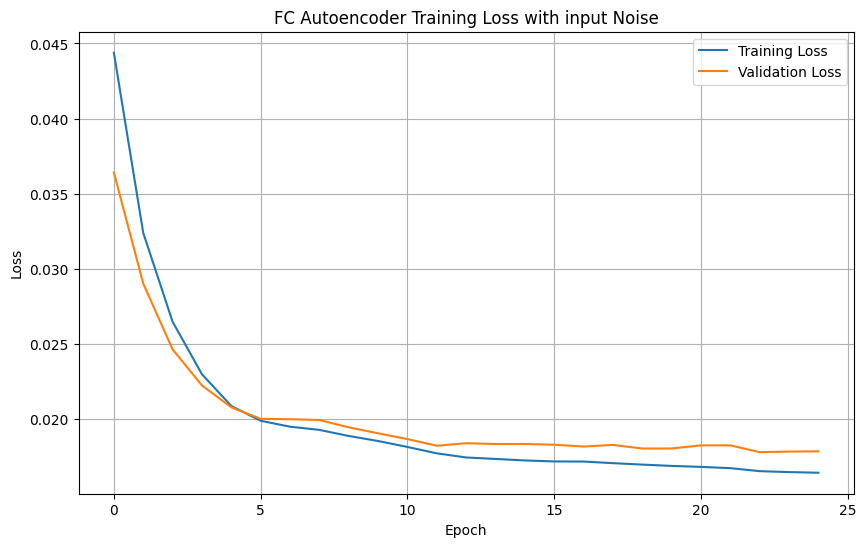

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float16)
  • training=True
  • mask=None

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from skimage import color
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, History
from sklearn.model_selection import train_test_split


# Parameters
IMAGE_SIZE = 32
BATCH_SIZE = 32
EPOCHS = 25
NOISE_MU = 0.0
NOISE_SIGMA = 0.2
LATENT_DIM = 64
GRAYSCALE = False  # Set this to True for grayscale, False for RGB
TEST_SIZE = 0.2  # Proportion of the dataset to use as testing set
TRAIN_SUBSET_SIZE = 0.2 # Proportion of training data to use

# Function to load and preprocess CIFAR-10
def load_and_preprocess_cifar10(grayscale=False, test_size=TEST_SIZE, train_subset_size = TRAIN_SUBSET_SIZE):
    (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0

    if grayscale:
        x_train = np.array([color.rgb2gray(img) for img in x_train])
        x_test = np.array([color.rgb2gray(img) for img in x_test])
        x_train = np.expand_dims(x_train, axis=-1)
        x_test = np.expand_dims(x_test, axis=-1)

    #Subsetting
    x_train = x_train[:int(len(x_train)*train_subset_size)]


    train_images, val_images = train_test_split(x_train, test_size=test_size, random_state=42)

    return train_images, x_test

def add_gaussian_noise(images, mu, sigma):
    noise = np.random.normal(mu, sigma, images.shape)
    return np.clip(images + noise, 0.0, 1.0).astype(np.float32)

# Fully Connected Autoencoder
def build_fc_autoencoder(input_shape, latent_dim):
    encoder = models.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(256, activation='relu'),
        layers.Dense(latent_dim, activation='relu')
    ])

    decoder = models.Sequential([
        layers.Dense(256, activation='relu', input_shape=(latent_dim,)),
        layers.Dense(np.prod(input_shape), activation='sigmoid'),
        layers.Reshape(input_shape)
    ])

    autoencoder = models.Sequential([encoder, decoder])
    return autoencoder, encoder, decoder

# CNN Autoencoder
def build_cnn_autoencoder(input_shape, latent_dim):
    encoder = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(latent_dim, activation='relu')  # Bottleneck
    ])

    decoder = models.Sequential([
        layers.Dense(np.prod(encoder.layers[-1].output_shape[1:]), activation='relu', input_shape=(latent_dim,)),
        layers.Reshape(target_shape=(encoder.layers[-3].output_shape[1], encoder.layers[-3].output_shape[2], encoder.layers[-3].output_shape[3])),
        layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2),
        layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2),
        layers.Conv2D(input_shape[-1], (3, 3), activation='sigmoid', padding='same')
    ])

    autoencoder = models.Sequential([encoder, decoder])

    return autoencoder, encoder, decoder


# Training function with different noise injection methods
def train_autoencoder(autoencoder, encoder, model_name, train_data, epochs, noise_mu, noise_sigma, noise_type='input'):
    optimizer = optimizers.Adam()
    autoencoder.compile(optimizer=optimizer, loss=losses.MeanSquaredError())
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = History() # Initialize history

    # Split training data into training and validation
    train_images, val_images = train_test_split(train_data, test_size=0.2, random_state=42)


    if noise_type == 'input':
        noisy_train_images = add_gaussian_noise(train_images, noise_mu, noise_sigma)
        noisy_val_images = add_gaussian_noise(val_images, noise_mu, noise_sigma)

        autoencoder.fit(noisy_train_images, train_images, epochs=epochs, batch_size=BATCH_SIZE,
                     validation_data=(noisy_val_images, val_images),
                     callbacks=[early_stopping, history], verbose=0)

    elif noise_type == 'latent':
        autoencoder.fit(train_images, train_images, epochs=epochs, batch_size=BATCH_SIZE,
                    validation_data=(val_images, val_images), callbacks=[early_stopping, history], verbose=0)

        # Precompute noisy latent vectors
        noisy_latent_train = []
        for img in train_images:
            latent_vector = encoder.predict(np.expand_dims(img, axis=0), verbose=0)
            noisy_latent_vector = add_gaussian_noise(latent_vector, noise_mu, noise_sigma)
            noisy_latent_train.append(noisy_latent_vector[0]) # Access only the numpy array
        noisy_latent_train = np.array(noisy_latent_train)

        noisy_latent_val = []
        for img in val_images:
            latent_vector = encoder.predict(np.expand_dims(img, axis=0), verbose=0)
            noisy_latent_vector = add_gaussian_noise(latent_vector, noise_mu, noise_sigma)
            noisy_latent_val.append(noisy_latent_vector[0]) # Access only the numpy array
        noisy_latent_val = np.array(noisy_latent_val)

        # Train using the noisy latent
        autoencoder.fit(noisy_latent_train, train_images, epochs=epochs, batch_size=BATCH_SIZE,
                     validation_data=(noisy_latent_val, val_images),
                     callbacks=[early_stopping, history], verbose=0)

    print(f"{model_name} trained with {noise_type} noise.")
    return autoencoder, encoder, history


# Plotting function for training history
def plot_training_history(history, model_type, noise_type):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_type.upper()} Autoencoder Training Loss with {noise_type} Noise')
    plt.legend()
    plt.grid(True)
    plt.show()


# Testing and Plotting
def test_and_plot(autoencoder, encoder, test_images, noise_mu, noise_sigma, model_type, noise_type):
    num_samples = min(5, len(test_images))  # Use a maximum of 5 images for plotting
    fig, axes = plt.subplots(num_samples, 3 if noise_type == 'input' else 4, figsize=(12, 3 * num_samples))
    if num_samples == 1:
        axes = np.array([axes])

    for i in range(num_samples):
        if noise_type == 'input':
          # Noisy Input
          noisy_input = add_gaussian_noise(np.expand_dims(test_images[i], axis=0), noise_mu, noise_sigma)
          predicted_output = autoencoder.predict(noisy_input, verbose=0)

          # Plot
          axes[i, 0].imshow(noisy_input[0])
          axes[i, 0].set_title(f'Noisy Input {i}')
          axes[i, 0].axis('off')
          axes[i, 1].imshow(predicted_output[0])
          axes[i, 1].set_title(f'Denoised {i}')
          axes[i, 1].axis('off')
          axes[i, 2].imshow(test_images[i])
          axes[i, 2].set_title(f'Original Input {i}')
          axes[i, 2].axis('off')
        else:  # 'latent' noise
          # Clear input, noisy latent
          latent_vector = encoder.predict(np.expand_dims(test_images[i], axis=0), verbose=0)
          noisy_latent_vector = add_gaussian_noise(latent_vector, noise_mu, noise_sigma)
          predicted_output = autoencoder.predict(noisy_latent_vector, verbose=0)


          # Plotting for latent noise injection
          axes[i, 0].imshow(test_images[i])
          axes[i, 0].set_title(f'Original Input {i}')
          axes[i, 0].axis('off')
          axes[i, 1].imshow(latent_vector[0])
          axes[i, 1].set_title(f'Compressed {i}')
          axes[i, 1].axis('off')
          axes[i, 2].imshow(noisy_latent_vector[0])
          axes[i, 2].set_title(f'Noisy Compressed {i}')
          axes[i, 2].axis('off')
          axes[i, 3].imshow(predicted_output[0])
          axes[i, 3].set_title(f'Denoised {i}')
          axes[i, 3].axis('off')

    plt.suptitle(f'{model_type.upper()} Autoencoder Denoising with {noise_type} Noise', y = 1.05)
    plt.tight_layout()
    plt.show()

# PCA Denoising
def pca_denoise(images, latent_dim):
    scaler = StandardScaler()
    scaled_images = scaler.fit_transform(images.reshape(images.shape[0], -1))

    pca = PCA(n_components=latent_dim)
    pca_fit = pca.fit(scaled_images)
    compressed_images = pca_fit.transform(scaled_images)

    reconstructed_images = pca_fit.inverse_transform(compressed_images)
    reconstructed_images = scaler.inverse_transform(reconstructed_images)

    return reconstructed_images.reshape(images.shape)

# Objective evaluation
def calculate_metrics(original, denoised):
    mse = mean_squared_error(original, denoised)
    psnr = peak_signal_noise_ratio(original, denoised)
    return mse, psnr

# Main Execution
if __name__ == '__main__':
    # Check for GPU availability and enable mixed precision training
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            tf.config.set_logical_device_configuration(
                gpus[0],
                [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
            tf.keras.mixed_precision.set_global_policy('mixed_float16')
            print("GPU is available and mixed precision enabled")
        except RuntimeError as e:
            print(e)
            print("GPU is available but mixed precision could not be enabled")



    else:
        print("GPU not available, using CPU.")

    #1- Data Loading and preprocessing
    train_images, test_images = load_and_preprocess_cifar10(GRAYSCALE)
    input_shape = train_images[0].shape

    #2 - Model creation and training
    # FC
    fc_autoencoder, fc_encoder, fc_decoder = build_fc_autoencoder(input_shape, LATENT_DIM)

    fc_autoencoder_input, fc_encoder_input, fc_history_input = train_autoencoder(fc_autoencoder, fc_encoder, "FC", train_images, EPOCHS, NOISE_MU, NOISE_SIGMA, noise_type='input')
    plot_training_history(fc_history_input, "FC", "input")

    fc_autoencoder_latent, fc_encoder_latent, fc_history_latent  = train_autoencoder(fc_autoencoder, fc_encoder, "FC", train_images, EPOCHS, NOISE_MU, NOISE_SIGMA, noise_type='latent')
    plot_training_history(fc_history_latent, "FC", "latent")

    # CNN
    cnn_autoencoder, cnn_encoder, cnn_decoder = build_cnn_autoencoder(input_shape, LATENT_DIM)

    cnn_autoencoder_input, cnn_encoder_input, cnn_history_input = train_autoencoder(cnn_autoencoder, cnn_encoder, "CNN", train_images, EPOCHS, NOISE_MU, NOISE_SIGMA, noise_type='input')
    plot_training_history(cnn_history_input, "CNN", "input")

    cnn_autoencoder_latent, cnn_encoder_latent, cnn_history_latent = train_autoencoder(cnn_autoencoder, cnn_encoder, "CNN", train_images, EPOCHS, NOISE_MU, NOISE_SIGMA, noise_type='latent')
    plot_training_history(cnn_history_latent, "CNN", "latent")

    #3 - Testing and plotting
    # FC
    test_and_plot(fc_autoencoder_input, fc_encoder_input, test_images, NOISE_MU, NOISE_SIGMA, "FC", "input")
    test_and_plot(fc_autoencoder_latent, fc_encoder_latent, test_images, NOISE_MU, NOISE_SIGMA, "FC", "latent")

    # CNN
    test_and_plot(cnn_autoencoder_input, cnn_encoder_input, test_images, NOISE_MU, NOISE_SIGMA, "CNN", "input")
    test_and_plot(cnn_autoencoder_latent, cnn_encoder_latent, test_images, NOISE_MU, NOISE_SIGMA, "CNN", "latent")

    # PCA Denoising and objective comparison
    print("\nPCA Denoising and Evaluation")
    pca_denoised_images = pca_denoise(test_images, LATENT_DIM)
    num_samples = min(5, len(test_images))
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 3 * num_samples))

    if num_samples == 1:
      axes = np.array([axes])

    for i in range(num_samples):
        axes[i, 0].imshow(test_images[i])
        axes[i, 0].set_title(f"Original Image {i}")
        axes[i, 0].axis('off')
        axes[i, 1].imshow(pca_denoised_images[i])
        axes[i, 1].set_title(f"PCA Denoised {i}")
        axes[i, 1].axis('off')

    plt.suptitle("PCA Denoising Results")
    plt.tight_layout()
    plt.show()

    # Calculate and print metrics
    for i in range(num_samples):
        pca_mse, pca_psnr = calculate_metrics(test_images[i], pca_denoised_images[i])
        print(f"Image {i} PCA - MSE: {pca_mse:.4f}, PSNR: {pca_psnr:.2f}")

    print("\nAutoencoder Denoising Evaluation")


    # FC Input
    for i in range(num_samples):
        noisy_test_input = add_gaussian_noise(np.expand_dims(test_images[i], axis=0), NOISE_MU, NOISE_SIGMA)
        fc_denoised_input = fc_autoencoder_input.predict(noisy_test_input, verbose=0)
        mse_fc_input, psnr_fc_input = calculate_metrics(test_images[i], fc_denoised_input[0])
        print(f"Image {i} FC (input Noise) - MSE: {mse_fc_input:.4f}, PSNR: {psnr_fc_input:.2f}")

     # FC Latent
    for i in range(num_samples):
        latent_test_input = fc_encoder_latent.predict(np.expand_dims(test_images[i], axis=0), verbose=0)
        noisy_latent_test_input = add_gaussian_noise(latent_test_input, NOISE_MU, NOISE_SIGMA)
        fc_denoised_latent = fc_autoencoder_latent.predict(noisy_latent_test_input, verbose=0)
        mse_fc_latent, psnr_fc_latent = calculate_metrics(test_images[i], fc_denoised_latent[0])
        print(f"Image {i} FC (latent Noise) - MSE: {mse_fc_latent:.4f}, PSNR: {psnr_fc_latent:.2f}")

    # CNN Input
    for i in range(num_samples):
        noisy_test_input = add_gaussian_noise(np.expand_dims(test_images[i], axis=0), NOISE_MU, NOISE_SIGMA)
        cnn_denoised_input = cnn_autoencoder_input.predict(noisy_test_input, verbose=0)
        mse_cnn_input, psnr_cnn_input = calculate_metrics(test_images[i], cnn_denoised_input[0])
        print(f"Image {i} CNN (input Noise) - MSE: {mse_cnn_input:.4f}, PSNR: {psnr_cnn_input:.2f}")

     # CNN Latent
    for i in range(num_samples):
        latent_test_input = cnn_encoder_latent.predict(np.expand_dims(test_images[i], axis=0), verbose=0)
        noisy_latent_test_input = add_gaussian_noise(latent_test_input, NOISE_MU, NOISE_SIGMA)
        cnn_denoised_latent = cnn_autoencoder_latent.predict(noisy_latent_test_input, verbose=0)
        mse_cnn_latent, psnr_cnn_latent = calculate_metrics(test_images[i], cnn_denoised_latent[0])
        print(f"Image {i} CNN (latent Noise) - MSE: {mse_cnn_latent:.4f}, PSNR: {psnr_cnn_latent:.2f}")